## Conditional GAN (cgan) for Furnace color prediction

Conditional Generative Adversarial Nets

Authors: Mehdi Mirza, Simon Osindero

Generative Adversarial Nets were recently introduced as a novel way to train generative models. In this work we introduce the conditional version of generative adversarial nets, which can be constructed by simply feeding the data, y, we wish to condition on to both the generator and discriminator. We show that this model can generate MNIST digits conditioned on class labels. We also illustrate how this model could be used to learn a multi-modal model, and provide preliminary examples of an application to image tagging in which we demonstrate how this approach can generate descriptive tags which are not part of training labels.

paper: https://arxiv.org/abs/1411.1784


In [1]:

import os
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
from fastai.vision.all import *

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
civs_path = '/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs'

In [3]:
opt_lr=0.0002              ##  help="adam: learning rate
opt_b1=0.5                 ##  help="adam: decay of first order momentum of gradient
opt_b2=0.999               ##  help="adam: decay of first order momentum of gradient
opt_n_cpu=8                ##  help="number of cpu threads to use during batch generation
opt_sample_interval=20    ## help="interval between image sampling")

In [4]:



opt_n_epochs=200           ##  help="number of epochs of training
opt_batch_size=8          ##  help="size of the batches
opt_latent_dim=100         ##  help="dimensionality of the latent space
opt_n_classes=11           ##  help="number of classes for dataset
opt_img_size= 226          ##    32            ##  help="size of each image dimension
opt_channels=3             ##  help="number of image channels



## Data and DataLoader

In [5]:
path = civs_path

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names

print(len(paths))
np.random.seed(123)
paths_subset = np.random.choice(paths, 615, replace=False) # choosing 493 images randomly
rand_idxs = np.random.permutation(615)

train_idxs = rand_idxs[:492] # choosing the first 492 as training set
val_idxs   = rand_idxs[492:] # choosing last 123 as validation set

train_paths = paths_subset[train_idxs]
val_paths   = paths_subset[val_idxs]

all_paths   = paths_subset[rand_idxs]

print(len(train_paths), len(val_paths))

615
492 123


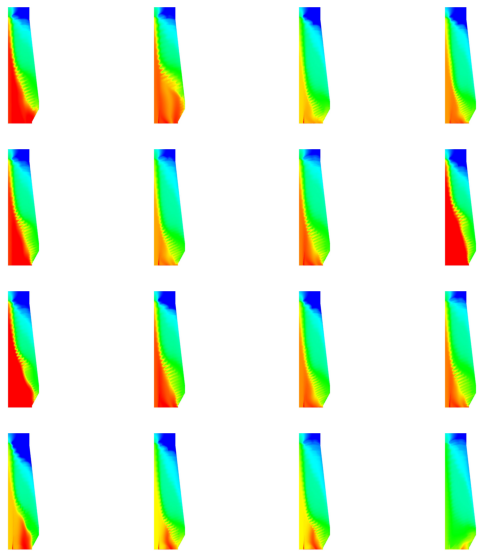

In [6]:


_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), all_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")



In [7]:

img_shape = (opt_channels, opt_img_size, opt_img_size)

cuda = True if torch.cuda.is_available() else False


In [8]:
img_shape

(3, 226, 226)

In [9]:
fns = get_image_files(path)

In [10]:
fns

(#615) [Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng120_Pci0_H0_Wp0_Ph400_Ox21_Ow7_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng37.9_Pci0_H0_Wp0_Ph300_Ox21_Ow6_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng90_Pci0_H0_Wp0_Ph300_Ox30_Ow9_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng70_Pci0_H0_Wp0_Ph300_Ox24_Ow3_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng0_Pci200_H0_Wp0_Ph300_Ox27_Ow5_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng30_Pci20_H0_Wp0_Ph300_Ox21_Ow5_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng90_Pci0_H0_Wp0_Ph500_Ox21_Ow7_Hbt1459.8_Wm12.2_Wr308750.4.jpg'),Path('/home/maquina1/

In [11]:
    
## ['tg', 'Ng0', 'Pci175', 'H0', 'Wp0', 'Ph300', 'Ox24', 'Ow7', 'Hbt1459.8', 'Wm12.2', 'Wr308750.4']
    
def label_func(fname):
    temp_name = fname.name.replace(".jpg", "").split("_")
    ## print(temp_name)
    
    y0 = 0.0                                        ## tg
    y1 = float(temp_name[1].replace("Ng", ""))     ## 'Ng0'
    y2 = float(temp_name[2].replace("Pci", ""))    ## 'Pci175'
    y3 = float(temp_name[3].replace("H", ""))     ## 'H0'
    y4 = float(temp_name[4].replace("Wp", ""))     ## 'Wp0'
    y5 = float(temp_name[5].replace("Ph", ""))     ## 'Ph300'
    y6 = float(temp_name[6].replace("Ox", ""))    ## 'Ox24'
    y7 = float(temp_name[7].replace("Ow", ""))     ## 'Ow7
    y8 = float(temp_name[8].replace("Hbt", ""))    ## 'Hbt1459.8'
    y9 = float(temp_name[9].replace("Wm", ""))    ## 'Wm12.2'
    y10 = float(temp_name[10].replace("Wr", ""))    ## 'Wr308750.4'
    
    return tensor([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 ])

In [12]:
    
## ['tg', 'Ng0', 'Pci175', 'H0', 'Wp0', 'Ph300', 'Ox24', 'Ow7', 'Hbt1459.8', 'Wm12.2', 'Wr308750.4']
    
def label_func2(fname):
    ## print(fname)
    fname = fname.replace("/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/","")
    temp_name = fname.replace(".jpg", "").split("_")
    ## print(temp_name)
    
    y0 = 0.0                                        ## tg
    y1 = float(temp_name[1].replace("Ng", ""))     ## 'Ng0'
    y2 = float(temp_name[2].replace("Pci", ""))    ## 'Pci175'
    y3 = float(temp_name[3].replace("H", ""))     ## 'H0'
    y4 = float(temp_name[4].replace("Wp", ""))     ## 'Wp0'
    y5 = float(temp_name[5].replace("Ph", ""))     ## 'Ph300'
    y6 = float(temp_name[6].replace("Ox", ""))    ## 'Ox24'
    y7 = float(temp_name[7].replace("Ow", ""))     ## 'Ow7
    y8 = float(temp_name[8].replace("Hbt", ""))    ## 'Hbt1459.8'
    y9 = float(temp_name[9].replace("Wm", ""))    ## 'Wm12.2'
    y10 = float(temp_name[10].replace("Wr", ""))    ## 'Wr308750.4'
    
    return np.array([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 ])

In [13]:
list_imgs = []
list_label_vectors = []

for img_name in all_paths:
    my_img = Image.open(img_name)
    
    my_img = my_img.resize((opt_img_size, opt_img_size))

    img_np = np.array(my_img)
    # print(img_np.shape)
    
    
    list_imgs.append(img_np)
    list_label_vectors.append(label_func2(img_name))



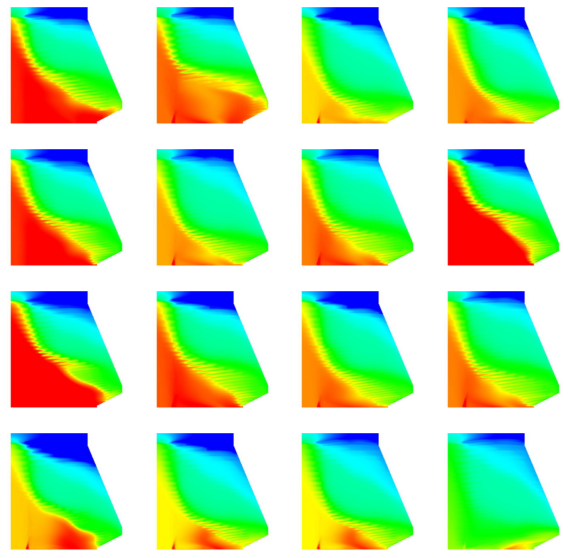

In [14]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), all_paths):
    a_img = Image.open(img_path)
    ax.imshow(a_img.resize((opt_img_size, opt_img_size)))
    ax.axis("off")


In [15]:
X = np.array( list_imgs)

y = np.array( list_label_vectors )

print(X.shape)
print(y.shape)



(615, 226, 226, 3)
(615, 11)


In [16]:
#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(492, 226, 226, 3)
(123, 226, 226, 3)
(492, 11)
(123, 11)


In [17]:


## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)





In [18]:
X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [19]:
X_train_tr  = torch.permute(X_train_tr , (0, 3, 1, 2))
X_test_tr   = torch.permute(X_test_tr ,  (0, 3, 1, 2))

In [20]:
print(X_train_tr.shape)
print(X_test_tr.shape)
print(y_train_tr.shape)
print(y_test_tr.shape)


torch.Size([492, 3, 226, 226])
torch.Size([123, 3, 226, 226])
torch.Size([492, 11])
torch.Size([123, 11])


In [21]:
'''
transform=transforms.Compose(
    [transforms.Resize(opt_img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

'''


train_ds = TensorDataset(X_train_tr, y_train_tr)





In [22]:


dls = DataLoader(
    train_ds, 
    batch_size=opt_batch_size, 
    shuffle=True
)

      

In [23]:

dataloader = dls



In [24]:
xb,yb = dataloader.one_batch()
xb.shape, yb.shape
     

(torch.Size([8, 3, 226, 226]), torch.Size([8, 11]))

In [25]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        ## self.label_emb2 = nn.Embedding(opt_n_classes, opt_n_classes)
        

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt_latent_dim + opt_n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and noise to produce input
        ### gen_input = torch.cat((self.label_emb(labels), noise), -1)
        ## print(labels.shape)
        ## print(noise.shape)
        gen_input = torch.cat((labels, noise), -1)
        ## print(gen_input.shape)
        img = self.model(gen_input)
        ## print(img.shape)
        img = img.view(img.size(0), *img_shape)
        return img

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt_n_classes, opt_n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt_n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), labels), -1)
        ## d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [27]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator     = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()



In [28]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(),     lr=opt_lr, betas=(opt_b1, opt_b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt_lr, betas=(opt_b1, opt_b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor if cuda else torch.LongTensor


In [29]:
def sample_image(n_row, batches_done):

    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt_latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "steel/%d.png" % batches_done, nrow=n_row, normalize=True)

# ----------
#  Training
# ----------


In [30]:




for epoch in range(opt_n_epochs):
    ## for batch in dataloader: ## .dataset:
    for i , (imgs, labels) in enumerate(dataloader):

        #(imgs, labels) = batch[0], batch[1]

        #transform = transforms.Compose([   transforms.ToTensor()    ])
        #imgs = transform(imgs)
        
        #imgs = imgs.unsqueeze(0)
        #labels = labels.unsqueeze(0)
        
        
        ## print(imgs.shape)
        ## print(labels.shape)
        
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake  = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        labels    = Variable(labels.type(LongTensor))
        real_imgs = Variable(imgs.type(FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z          = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt_latent_dim))))
        ## gen_labels = Variable(LongTensor( np.random.randint(0, opt_n_classes, batch_size)))
        


        # Generate a batch of images
        ## gen_imgs = generator(z, gen_labels)
        gen_imgs = generator(z, labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, labels)
        g_loss   = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss   = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), labels)
        d_fake_loss   = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt_n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt_sample_interval == 0:
            ## sample_image(n_row=10, batches_done=batches_done)
            a = 3
            
        
            
            

[Epoch 0/200] [Batch 0/62] [D loss: 2463.213135] [G loss: 1266.337646]
[Epoch 1/200] [Batch 0/62] [D loss: 8509.415039] [G loss: 598.444946]
[Epoch 2/200] [Batch 0/62] [D loss: 2866.373291] [G loss: 290.770721]
[Epoch 3/200] [Batch 0/62] [D loss: 1613.589722] [G loss: 165.209930]
[Epoch 4/200] [Batch 0/62] [D loss: 691.797668] [G loss: 149.922485]
[Epoch 5/200] [Batch 0/62] [D loss: 349.429291] [G loss: 57.365471]
[Epoch 6/200] [Batch 0/62] [D loss: 1240.728271] [G loss: 97.733383]
[Epoch 7/200] [Batch 0/62] [D loss: 358.269714] [G loss: 70.335037]
[Epoch 8/200] [Batch 0/62] [D loss: 244.276398] [G loss: 57.089275]
[Epoch 9/200] [Batch 0/62] [D loss: 289.822723] [G loss: 56.055885]
[Epoch 10/200] [Batch 0/62] [D loss: 213.705841] [G loss: 48.904175]
[Epoch 11/200] [Batch 0/62] [D loss: 84.326324] [G loss: 26.881739]
[Epoch 12/200] [Batch 0/62] [D loss: 446.694702] [G loss: 24.956408]
[Epoch 13/200] [Batch 0/62] [D loss: 74.814423] [G loss: 15.761549]
[Epoch 14/200] [Batch 0/62] [D loss

[Epoch 116/200] [Batch 0/62] [D loss: 25098.365234] [G loss: 73.304802]
[Epoch 117/200] [Batch 0/62] [D loss: 10443.378906] [G loss: 58.929565]
[Epoch 118/200] [Batch 0/62] [D loss: 34687.425781] [G loss: 62.874817]
[Epoch 119/200] [Batch 0/62] [D loss: 27153.451172] [G loss: 54.242889]
[Epoch 120/200] [Batch 0/62] [D loss: 29188.759766] [G loss: 9.886461]
[Epoch 121/200] [Batch 0/62] [D loss: 50071.296875] [G loss: 69.983932]
[Epoch 122/200] [Batch 0/62] [D loss: 39896.472656] [G loss: 39.529404]
[Epoch 123/200] [Batch 0/62] [D loss: 42473.886719] [G loss: 46.610245]
[Epoch 124/200] [Batch 0/62] [D loss: 45183.453125] [G loss: 25.060955]
[Epoch 125/200] [Batch 0/62] [D loss: 9907.545898] [G loss: 41.464142]
[Epoch 126/200] [Batch 0/62] [D loss: 25244.162109] [G loss: 27.730633]
[Epoch 127/200] [Batch 0/62] [D loss: 19265.003906] [G loss: 40.905815]
[Epoch 128/200] [Batch 0/62] [D loss: 24035.265625] [G loss: 16.390875]
[Epoch 129/200] [Batch 0/62] [D loss: 6014.459961] [G loss: 21.000